## Imports Section: Importing Necessary Packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM , Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import os
import nbformat

## Setting Base Path for File Operations.

In [2]:
def set_base_path(base_path):
    """
    Set the base path for file operations.

    Parameters:
    - base_path (str): The base path to set.

    Returns:
    - None
    """
    global BASE_PATH
    BASE_PATH = base_path

def construct_file_path(relative_path):
    """
    Construct the full file path using the base path and the relative path.

    Parameters:
    - relative_path (str): The relative path from the base path.

    Returns:
    - full_path (str): The full file path.
    """
    if 'BASE_PATH' not in globals():
        raise ValueError("Base path is not set. Call set_base_path() first.")

    full_path = os.path.join(BASE_PATH, relative_path)
    return full_path

# usage
set_base_path(r"F:\DataScience\code\stock-prediction")

In [3]:
# Loading CNN Model Notebook.
def load_notebook(file_path):
    """
    Load a Jupyter Notebook file (.ipynb).

    Parameters:
    - file_path (str): The path to the .ipynb file.

    Returns:
    - notebook (NotebookNode): The loaded notebook object.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        notebook = nbformat.read(file, as_version=4)
    return notebook

# usage
file_path = construct_file_path("notebooks/CNN_Model.ipynb")
cnn_model_notebook = load_notebook(file_path)

## Ignore Warning.

In [4]:
import warnings
    
warnings.filterwarnings("ignore")

## Model Architecture: Reading DataFrames and display it.

In [5]:
# Construct the full file path for data/AAPL_use(1).csv
file_path_1 = construct_file_path("data/AAPL_use(1).csv")

# Now you can use file_path to read the CSV file
df1 = pd.read_csv(file_path_1)

print(df1['Close'].shape)

(4027,)


In [25]:
# Construct the full file path for data/AAPL_use(2).csv
file_path_2 = construct_file_path("data/AAPL_use(2).csv")

# Now you can use file_path to read the CSV file
df2 = pd.read_csv(file_path_2)

print(df2['Close'].shape)

(1762,)


In [26]:
# Removing %h-%m-%s From Date Column in df1
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Date'] = df1['Date'].dt.strftime('%d-%m-%Y')
print(df1)

            Date        Open        High         Low       Close   Adj Close  \
0     30-10-2007    6.649286    6.763214    6.597500    6.678571    5.668749   
1     31-10-2007    6.701071    6.790000    6.605357    6.783929    5.758174   
2     01-11-2007    6.735714    6.789286    6.428571    6.694286    5.682087   
3     02-11-2007    6.757500    6.765714    6.553214    6.709643    5.695121   
4     05-11-2007    6.617500    6.748571    6.580000    6.649286    5.643891   
...          ...         ...         ...         ...         ...         ...   
4022  23-10-2023  170.910004  174.009995  169.929993  173.000000  173.000000   
4023  24-10-2023  173.050003  173.669998  171.449997  173.440002  173.440002   
4024  25-10-2023  171.880005  173.059998  170.649994  171.100006  171.100006   
4025  26-10-2023  170.369995  171.380005  165.669998  166.889999  166.889999   
4026  27-10-2023  166.910004  168.960007  166.830002  168.220001  168.220001   

          Volume  
0      939414000  
1

In [27]:
# Assuming df1 and df2 are your DataFrames
# Concatenate df1 and df2 along the rows (axis=0)
df = pd.concat([df1, df2], axis=0)

# Reset index if needed
df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
print(df)

            Date        Open        High         Low       Close  Adj Close  \
0     30-10-2007    6.649286    6.763214    6.597500    6.678571   5.668749   
1     31-10-2007    6.701071    6.790000    6.605357    6.783929   5.758174   
2     01-11-2007    6.735714    6.789286    6.428571    6.694286   5.682087   
3     02-11-2007    6.757500    6.765714    6.553214    6.709643   5.695121   
4     05-11-2007    6.617500    6.748571    6.580000    6.649286   5.643891   
...          ...         ...         ...         ...         ...        ...   
5784  23-12-2016  115.589996  116.519997  115.589996  116.519997        NaN   
5785  27-12-2016  116.519997  117.800003  116.489998  117.260002        NaN   
5786  28-12-2016  117.519997  118.019997  116.199997  116.760002        NaN   
5787  29-12-2016  116.449997  117.110001  116.400002  116.730003        NaN   
5788  30-12-2016  116.650002  117.199997  115.430000  115.820000        NaN   

          Volume  ADJ Close Stock  
0      93941400

## Check For Missing.

In [28]:
# Calculate the number of missing values in each column of the 'df' DataFrame.

missing = df.isnull().sum()
print(missing)

Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Adj Close          1762
Volume                0
ADJ Close Stock    4027
dtype: int64


In [29]:
# Remove the "Adj Close" and "ADJ Close Stock" columns
df = df.drop(["Adj Close", "ADJ Close Stock"], axis=1)

# Display the modified DataFrame
print(df)

            Date        Open        High         Low       Close      Volume
0     30-10-2007    6.649286    6.763214    6.597500    6.678571   939414000
1     31-10-2007    6.701071    6.790000    6.605357    6.783929   833310800
2     01-11-2007    6.735714    6.789286    6.428571    6.694286   805036400
3     02-11-2007    6.757500    6.765714    6.553214    6.709643  1002114400
4     05-11-2007    6.617500    6.748571    6.580000    6.649286   804176800
...          ...         ...         ...         ...         ...         ...
5784  23-12-2016  115.589996  116.519997  115.589996  116.519997    14249500
5785  27-12-2016  116.519997  117.800003  116.489998  117.260002    18296900
5786  28-12-2016  117.519997  118.019997  116.199997  116.760002    20905900
5787  29-12-2016  116.449997  117.110001  116.400002  116.730003    15039500
5788  30-12-2016  116.650002  117.199997  115.430000  115.820000    30586300

[5789 rows x 6 columns]


In [31]:
# Recalculate missing values
missing = df.isnull().sum()
print(missing)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [32]:
# Checking The Type Of Data Column(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5789 entries, 0 to 5788
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5789 non-null   object 
 1   Open    5789 non-null   float64
 2   High    5789 non-null   float64
 3   Low     5789 non-null   float64
 4   Close   5789 non-null   float64
 5   Volume  5789 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 271.5+ KB


In [33]:
# Converting Object To Datetime in df1
df1['Date'] = pd.to_datetime(df1['Date'], dayfirst=True)
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027 entries, 0 to 4026
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4027 non-null   datetime64[ns]
 1   Open       4027 non-null   float64       
 2   High       4027 non-null   float64       
 3   Low        4027 non-null   float64       
 4   Close      4027 non-null   float64       
 5   Adj Close  4027 non-null   float64       
 6   Volume     4027 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 220.4 KB
None


In [34]:
# Converting Object To Datetime in df2
df2['Date'] = pd.to_datetime(df2['Date'], dayfirst=True)
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1762 non-null   datetime64[ns]
 1   Open             1762 non-null   float64       
 2   High             1762 non-null   float64       
 3   Low              1762 non-null   float64       
 4   Close            1762 non-null   float64       
 5   Volume           1762 non-null   int64         
 6   ADJ Close Stock  1762 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 96.5 KB
None


## Plotting Date and Close Price.

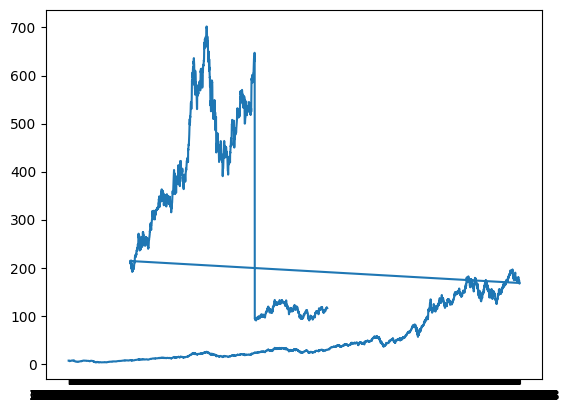

In [35]:
plt.plot(df['Date'],df['Close'])

In [36]:
print(df.shape)

(5789, 6)


## create a new dataframe with only the Close column.

In [37]:
data = df['Close'].values.reshape(-1, 1) # (rows , Columns)
print(data)

[[  6.678571]
 [  6.783929]
 [  6.694286]
 ...
 [116.760002]
 [116.730003]
 [115.82    ]]


In [38]:
print(data.shape)

(5789, 1)


## preprocessing: Normalize the data.

In [39]:
# Creating a MinMaxScaler instance
# The MinMaxScaler scales features to a specified range (by default, each feature is scaled to the [0, 1] range)
scaler = MinMaxScaler()

# Transforming the features using Min-Max scaling
# The fit_transform() method first fits the scaler to the data (computing the minimum and maximum values)
# Then, it transforms the data based on the computed minimum and maximum values
# The resulting values are scaled to the specified range
data_normalized = scaler.fit_transform(data)

# Printing the normalized data
print(data_normalized)

[[0.00555652]
 [0.00570718]
 [0.00557899]
 ...
 [0.16297151]
 [0.16292861]
 [0.16162732]]


## Data Preparation: Converting an Array of Values into a Dataset Matrix.

In [40]:
def prepare_data(data, time_steps):
    """
    Prepare the data for sequence modeling by converting an array of values into a dataset matrix.

    Parameters:
    - data: The input data as a numpy array.
    - time_steps: The number of time steps to consider for each sample.

    Returns:
    - X: The input features matrix.
    - y: The target variable vector.
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        """Extract a sequence of data points of length 'time_steps' as input features (X)."""
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
        if i <= 1:
            """Print the first few samples of X and y for debugging purposes."""
            print("X:", X)
            print("y:", y)
            print()
            
    return np.array(X), np.array(y)

time_steps = 10  
X, y = prepare_data(data_normalized, time_steps)

X: [array([0.00555652, 0.00570718, 0.00557899, 0.00560095, 0.00551464,
       0.00580115, 0.00552077, 0.00496767, 0.00445185, 0.00385892])]
y: [0.004686271167672466]

X: [array([0.00555652, 0.00570718, 0.00557899, 0.00560095, 0.00551464,
       0.00580115, 0.00552077, 0.00496767, 0.00445185, 0.00385892]), array([0.00570718, 0.00557899, 0.00560095, 0.00551464, 0.00580115,
       0.00552077, 0.00496767, 0.00445185, 0.00385892, 0.00468627])]
y: [0.004686271167672466, 0.004489647985359407]



In [41]:
print(X.shape)

(5779, 10)


## Reshape the data.

In [42]:
# This reshaping ensures that the input data has the shape (num_samples, num_time_steps, num_features) as expected by the LSTM layers.
X = np.reshape(X, (X.shape[0], X.shape[1] , 1))  
print(X.shape)

(5779, 10, 1)


In [43]:
print("X: ", X)

X:  [[[0.00555652]
  [0.00570718]
  [0.00557899]
  ...
  [0.00496767]
  [0.00445185]
  [0.00385892]]

 [[0.00570718]
  [0.00557899]
  [0.00560095]
  ...
  [0.00445185]
  [0.00385892]
  [0.00468627]]

 [[0.00557899]
  [0.00560095]
  [0.00551464]
  ...
  [0.00385892]
  [0.00468627]
  [0.00448965]]

 ...

 [[0.16072643]
  [0.16072643]
  [0.16162732]
  ...
  [0.16229942]
  [0.16262831]
  [0.1636865 ]]

 [[0.16072643]
  [0.16162732]
  [0.16184182]
  ...
  [0.16262831]
  [0.1636865 ]
  [0.16297151]]

 [[0.16162732]
  [0.16184182]
  [0.16279991]
  ...
  [0.1636865 ]
  [0.16297151]
  [0.16292861]]]


In [44]:
# Split the data into 60% train, 20% validation, and 20% test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the lengths of the sets
print("Training set length:", len(X_train))
print("Validation set length:", len(X_validation))
print("Test set length:", len(X_test))

Training set length: 3467
Validation set length: 1156
Test set length: 1156


## Parameter Settings: Define the LSTM model.

In [45]:
# Initialize a Sequential model
model = Sequential()

# Add the first LSTM layer to the model
# - LSTM units: 64 number of LSTM units or neurons in the layer.
# - Activation function: hyperbolic tangent (tanh)
# - Return sequences: True (to return the full sequence of outputs)
# - input_shape=(time_steps, 1): time_steps represents the number of time steps in each input sequence, and 1 indicates that there is only one feature per time step.
model.add(LSTM(units=64, activation='tanh', return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.2))

# Add the second LSTM layer to the model
# - LSTM units: 64 number of LSTM units or neurons in the layer.
# - Activation function: tanh or sigmoid
# - Return sequences: False so, it only returns the last output.
model.add(LSTM(units=64, activation='tanh'))  
model.add(Dropout(0.2))

# Add a dense output layer to the model
# - Single neuron in the output layer
model.add(Dense(units=1))

# Compile the model
# - Optimizer: Adam used to update network weights iteratively based on training data.
# - Loss function: MSE used to measure the difference between the model's predictions and the actual target values during training. 
model.compile(optimizer='adam', loss='mean_squared_error')

## Training Process: Train the model.

In [46]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
28/28 - 9s - 333ms/step - loss: 0.0127 - val_loss: 0.0012
Epoch 2/50
28/28 - 1s - 37ms/step - loss: 0.0017 - val_loss: 5.2635e-04
Epoch 3/50
28/28 - 1s - 36ms/step - loss: 0.0014 - val_loss: 6.2039e-04
Epoch 4/50
28/28 - 1s - 35ms/step - loss: 0.0013 - val_loss: 8.1944e-04
Epoch 5/50
28/28 - 1s - 38ms/step - loss: 0.0011 - val_loss: 6.8154e-04
Epoch 6/50
28/28 - 1s - 37ms/step - loss: 0.0011 - val_loss: 4.7966e-04
Epoch 7/50
28/28 - 1s - 39ms/step - loss: 0.0012 - val_loss: 4.7101e-04
Epoch 8/50
28/28 - 1s - 39ms/step - loss: 0.0010 - val_loss: 4.7157e-04
Epoch 9/50
28/28 - 1s - 37ms/step - loss: 0.0011 - val_loss: 5.2525e-04
Epoch 10/50
28/28 - 1s - 33ms/step - loss: 0.0010 - val_loss: 5.4166e-04
Epoch 11/50
28/28 - 1s - 36ms/step - loss: 0.0010 - val_loss: 4.4989e-04
Epoch 12/50
28/28 - 1s - 36ms/step - loss: 8.8586e-04 - val_loss: 4.2774e-04
Epoch 13/50
28/28 - 1s - 36ms/step - loss: 8.5088e-04 - val_loss: 4.3437e-04
Epoch 14/50
28/28 - 1s - 36ms/step - loss: 9.8951e-04 -

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,957 (585.77 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,972 (390.52 KB)

## Compile the model.

In [48]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics=['accuracy'])

In [49]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [50]:
# Train model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.0000e+00 - loss: 8.0048e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.4916e-04
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0000e+00 - loss: 5.8885e-04 - val_accuracy: 0.0000e+00 - val_loss: 6.5738e-04
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0000e+00 - loss: 7.0849e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.6928e-04
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0000e+00 - loss: 5.0904e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.7162e-04
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0000e+00 - loss: 8.7416e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.8425e-04
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0000e+00 - loss: 4.3050e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.4023e-04
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0000e+00 - loss: 4.0983e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.4

## Evaluation: Evaluate model.

In [51]:
# Evaluate the model on the training data to compute the loss and accuracy
train_loss = model.evaluate(X_train, y_train, verbose=0)

# Evaluate the model on the test data to compute the loss and accuracy
test_loss = model.evaluate(X_test, y_test, verbose=0)

# Print the training and test loss
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')


Train Loss: [5.97359066887293e-05, 0.0]
Test Loss: [3.470365118118934e-05, 0.0]


## Get the models predicted price values.

In [52]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


## Results: Calculate R2 score and MSE for testing data.

In [53]:
# Calculate R2 score and mean squared error for test set
test_r2 = r2_score(y_test.reshape(-1), test_predictions.reshape(-1))
test_mse = mean_squared_error(y_test.reshape(-1), test_predictions.reshape(-1))

# Calculate R2 score and mean squared error for train set
train_r2 = r2_score(y_train.reshape(-1), train_predictions.reshape(-1))
train_mse = mean_squared_error(y_train.reshape(-1), train_predictions.reshape(-1))

In [54]:
# Print evaluation metrics
print(f'Training R2 Score: {train_r2}')
print(f'Training Mean Squared Error: {train_mse}')
print(f'Testing R2 Score: {test_r2}')
print(f'Testing Mean Squared Error: {test_mse}') 

Training R2 Score: 0.9989035054591612
Training Mean Squared Error: 5.973588861928161e-05
Testing R2 Score: 0.9993591533588556
Testing Mean Squared Error: 3.470365027828449e-05


In [55]:
scaler.inverse_transform(y_train.reshape(-1, 1))
len(y_train) + len(y_test)

4623

## Make predictions.

In [56]:
y_pred = model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


## Inverse transform the predictions and actual values.

In [57]:
y_pred = scaler.inverse_transform(y_pred)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

In [58]:
# Calculate R2 score
r2 = r2_score(y_test_orig, y_pred)
print("R2 Score:", r2)

R2 Score: 0.9993591534191129


In [59]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test_orig, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 16.971142185569857


## Saving model weights.

In [60]:
# Define the absolute path to the directory to save the model weights
weights_folder_path = r"F:\DataScience\code\stock-prediction\saved_models"

# Ensure that the directory exists, create it if it doesn't
os.makedirs(weights_folder_path, exist_ok=True)

# Define the filename with the desired suffix
weights_filename = "model_weights.weights.h5"

# Define the file path to save the model weights inside the folder
weights_file_path = os.path.join(weights_folder_path, weights_filename)

# Save the model weights
model.save_weights(weights_file_path)

print("Model weights saved successfully in the 'saved_models' folder.")

Model weights saved successfully in the 'saved_models' folder.


## Visualization: Plotting predictions.

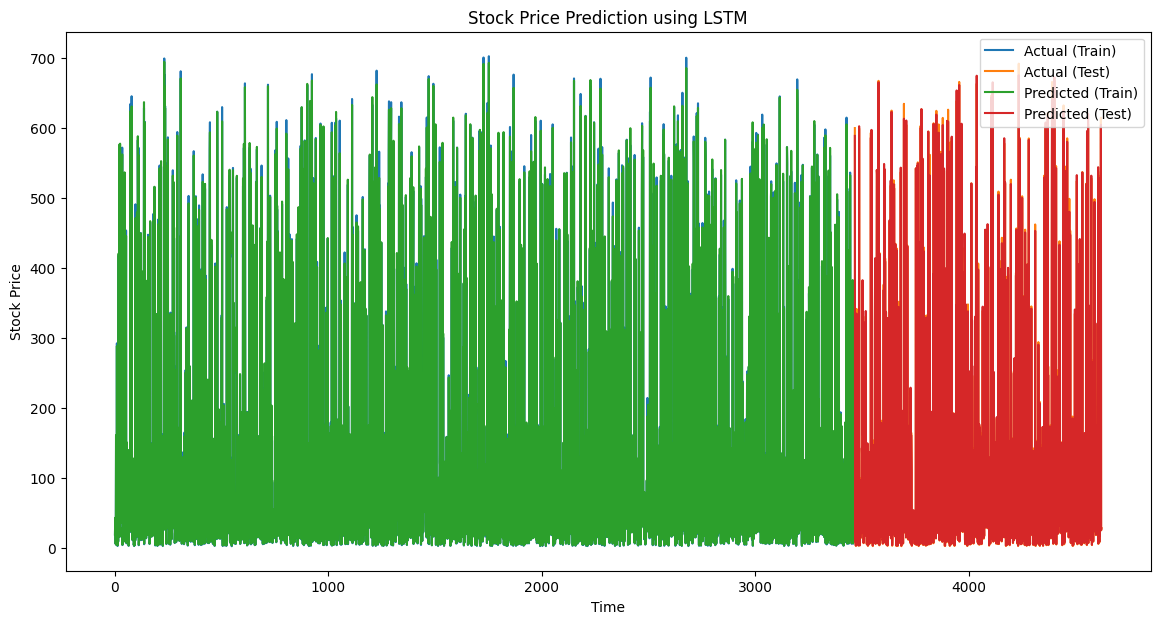

In [61]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Actual (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual (Test)')
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(train_predictions), label='Predicted (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(test_predictions), label='Predicted (Test)')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Plotting training history.

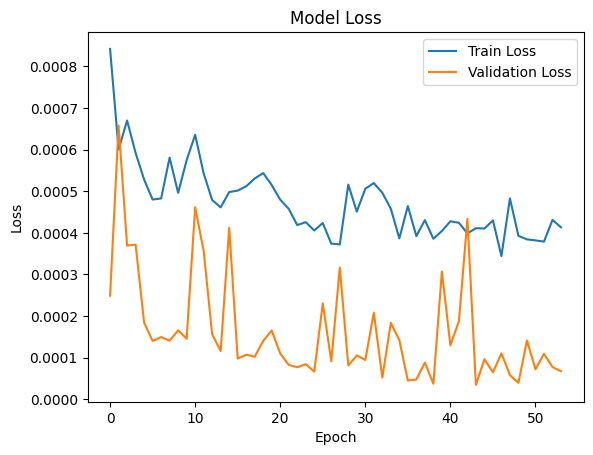

In [62]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plotting the actual vs. predicted values.

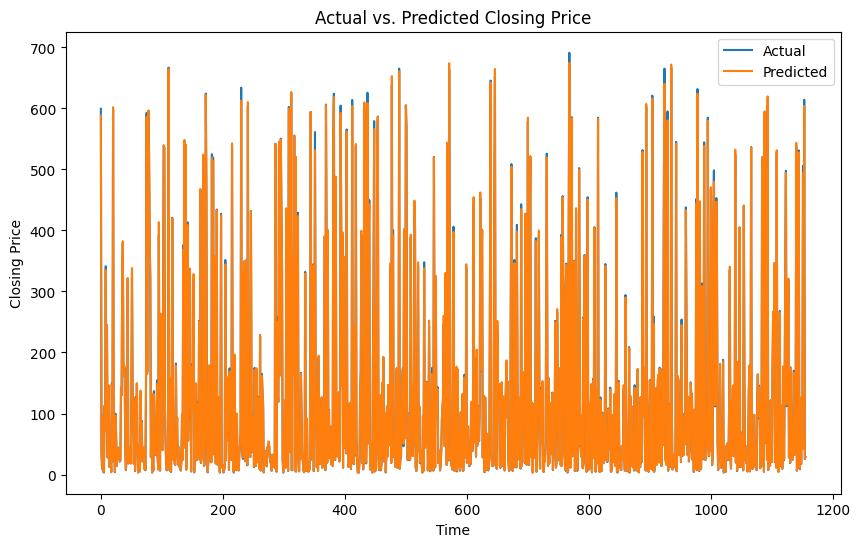

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs. Predicted Closing Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## Plot actual vs predicted closing prices.

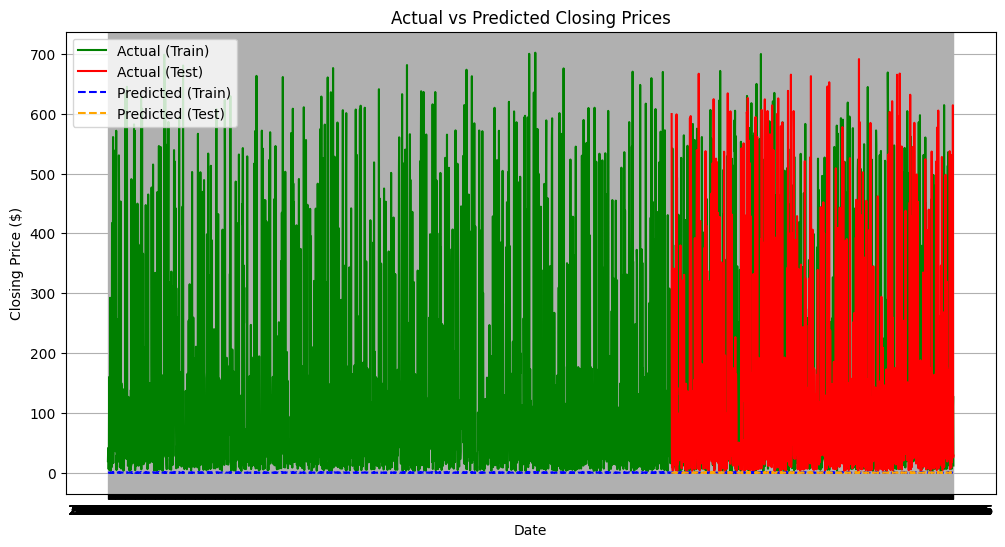

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_train_orig):], y_train_orig, label='Actual (Train)', color='green')
plt.plot(df['Date'][-len(y_test_orig):], y_test_orig, label='Actual (Test)', color='red')
plt.plot(df['Date'][-len(train_predictions):], train_predictions, label='Predicted (Train)', linestyle='--', color='blue')
plt.plot(df['Date'][-len(test_predictions):], test_predictions, label='Predicted (Test)', linestyle='--', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.show()

## Comparison: Plotting the Actual vs. Predicted Values using CNN vs LSTM.

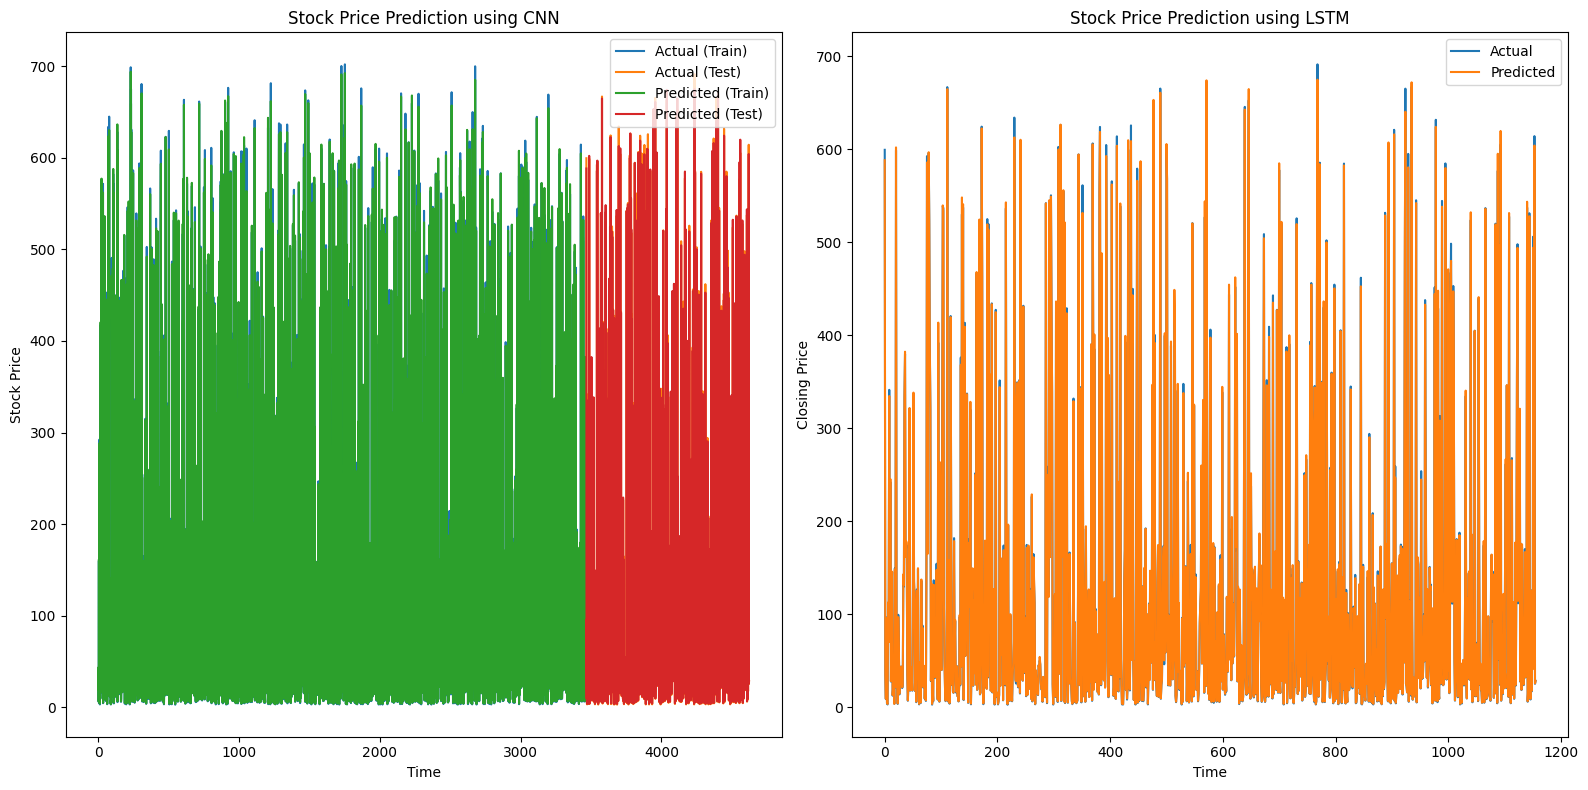

In [65]:
plt.figure(figsize=(16, 8))

# Plot predictions using CNN
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Actual (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual (Test)')
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(train_predictions), label='Predicted (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(test_predictions), label='Predicted (Test)')
plt.title('Stock Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Plot predictions using the other method
plt.subplot(1, 2, 2)
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

plt.tight_layout()
plt.show()


# Summary: Stock Prediction using LSTM Model.

### Introduction
The Long Short-Term Memory (LSTM) model is a type of recurrent neural network (RNN) that excels at capturing long-term dependencies in sequential data, making it well-suited for time series prediction tasks such as stock price forecasting.

### Model Architecture
Our LSTM model consists of multiple LSTM layers followed by a dense output layer. Each LSTM layer contains memory cells that retain information over time, allowing the model to learn complex patterns in the input sequences.

### Parameter Settings
- Number of LSTM units: 64
- Activation functions: tanh (for LSTM layers), linear (for output layer)
- Optimization algorithm: Adam

### Training Process
The LSTM model is trained on the training dataset after preprocessing steps such as data normalization. During training, the model minimizes the mean squared error loss function using the Adam optimizer.

### Evaluation
The trained LSTM model is evaluated on the test dataset to assess its performance. Performance metrics such as mean squared error (MSE) and R-squared are calculated to measure the model's accuracy in predicting stock prices.

### Results
The LSTM model demonstrates strong performance in predicting stock prices, as evidenced by low MSE and high R-squared values. Visualizations of the model's predictions compared to the actual values further illustrate its effectiveness.

### Conclusion
In conclusion, the LSTM model proves to be a powerful tool for stock price prediction, leveraging its ability to capture long-term dependencies in sequential data. Further experimentation and fine-tuning may yield even better results in real-world applications.
